# SIIM-FISABIO-RSNA COVID-19 Detection

In [1]:
# list folder content
! ls /home/jovyan/work/siim-covid19-detection -l

total 1688
-rw-rw-r--    1 jovyan users   89094 May 19 23:03 sample_submission.csv
drwxrwsr-x 1216 jovyan users   36864 May 20 16:30 test
drwxrwsr-x 6056 jovyan users  167936 May 20 16:30 train
-rw-rw-r--    1 jovyan users 1266705 May 19 23:03 train_image_level.csv
-rw-rw-r--    1 jovyan users  163548 May 19 23:03 train_study_level.csv


## Prepare environment

In [ ]:
# ! pip install -qU "numpy>=1.20" --no-binary numpy --no-build-isolation
! pip install -q python-gdcm
# ! pip install -q pylibjpeg-libjpeg pylibjpeg-openjpeg
# ! pip install -qU "pylibjpeg==1.2" --no-binary :all:
! pip install -qU pydicom opencv-python-headless # "torchvision==0.8" "torch==1.7"
! pip install -q https://github.com/airctic/icevision/archive/refs/heads/master.zip
! pip install -q kaggle_COVID_detection-*.whl
! pip list | grep torch
! pip list | grep lightning
! pip list | grep dicom
! pip list | grep jpeg
! nvidia-smi

%load_ext autoreload
%autoreload 2

import pydicom  # , pylibjpeg, openjpeg, libjpeg
print(getattr(pydicom.config, "gdcm_handler").is_available())
print(getattr(pydicom.config, "pylibjpeg_handler").is_available())

## Data exploration

Checking what data do we have available and what is the labels distribution...

- load and show raw tables
- enrich tables with counts
- merge tables together
- show simple stats

### Overview & Annotations

Starting with checking what is the provided tables...

In [3]:
%matplotlib inline

import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

BASE_PATH = '/home/jovyan/work/siim-covid19-detection'
LABELS = ("Negative for Pneumonia", "Typical Appearance", "Indeterminate Appearance", "Atypical Appearance")
LABELS_SHORT = ("negative", "typical", "indeterminate", "atypical")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**train_image_level.csv** - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.

- `id` - unique image identifier
- `boxes` - bounding boxes in easily-readable dictionary format
- `label` - the correct prediction label for the provided bounding boxes

In [4]:
path_csv_image = os.path.join(BASE_PATH, 'train_image_level.csv')
train_images = pd.read_csv(path_csv_image, index_col="id").sort_values("StudyInstanceUID")
train_images["name"] = [v.split('_')[0] for v in train_images.index]
train_images["boxes"] = train_images["boxes"].apply(lambda v: eval(v) if not isinstance(v, float) else None)
train_images["#boxes"] = train_images["boxes"].apply(lambda v: len(v) if v else 0)

imgs_paths = [glob.glob(os.path.join(BASE_PATH, 'train', row['StudyInstanceUID'], '*', f"{row['name']}.*")) for _, row in train_images.iterrows()]
print(f"max images shall be one and is: {max([len(p) for p in imgs_paths])}")
train_images["path"] = [os.path.sep.join(p[0].split(os.path.sep)[-4:]) for p in imgs_paths]

display(train_images.head())
print(len(train_images))

max images shall be one and is: 1


,boxes,label,StudyInstanceUID,name,#boxes,path
id,,,,,,
65761e66de9f_image,"[{'x': 720.65215, 'y': 636.51048, 'width': 332...",opacity 1 720.65215 636.51048 1052.84563 1284....,00086460a852,65761e66de9f,2,train/00086460a852/9e8302230c91/65761e66de9f.dcm
51759b5579bc_image,None,none 1 0 0 1 1,000c9c05fd14,51759b5579bc,0,train/000c9c05fd14/e555410bd2cd/51759b5579bc.dcm
f6293b1c49e2_image,None,none 1 0 0 1 1,00292f8c37bd,f6293b1c49e2,0,train/00292f8c37bd/73120b4a13cb/f6293b1c49e2.dcm
3019399c31f4_image,None,none 1 0 0 1 1,005057b3f880,3019399c31f4,0,train/005057b3f880/e34afce999c5/3019399c31f4.dcm
bb4b1da810f3_image,"[{'x': 812.54698, 'y': 1376.41291, 'width': 62...",opacity 1 812.54698 1376.41291 1435.14793 1806...,0051d9b12e72,bb4b1da810f3,2,train/0051d9b12e72/152f6ec68d86/bb4b1da810f3.dcm


6334


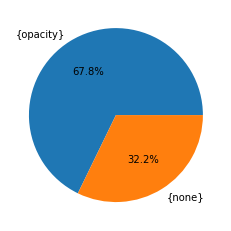

In [5]:
train_images["label_"] = train_images["label"].apply(lambda lb: lb.split()[::6])
train_images["label__"] = train_images["label_"].apply(lambda lb: set(lb))
ax = train_images["label__"].value_counts().plot.pie(ylabel="", autopct="%.1f%%")

In [6]:
labels_none = [lb for lb in train_images["label"] if lb.startswith("none")]
print(set(labels_none))

{'none 1 0 0 1 1'}


In [7]:
labels_1 = [tuple(lb.split()[1::6]) for lb in train_images["label"]]
print(set(labels_1))

{('1',), ('1', '1', '1'), ('1', '1', '1', '1', '1', '1', '1', '1'), ('1', '1', '1', '1'), ('1', '1', '1', '1', '1'), ('1', '1')}


**train_study_level.csv** - the train study-level metadata, with one row for each study, including correct labels.

- `id` - unique study identifier
- `Negative for Pneumonia` - 1 if the study is negative for pneumonia, 0 otherwise
- `Typical Appearance` - 1 if the study has this appearance, 0 otherwise
- `Indeterminate Appearance`  - 1 if the study has this appearance, 0 otherwise
- `Atypical Appearance` - if the study has this appearance, 0 otherwise


In [8]:
path_csv_study = os.path.join(BASE_PATH, 'train_study_level.csv')
train_study = pd.read_csv(path_csv_study, index_col="id").sort_values("id")
train_study["id_"] = [v.split('_')[0] for v in train_study.index]
train_study["class"] = [np.argmax(row.values) for _, row in train_study[list(LABELS)].iterrows()]
display(train_study.head())
print(len(train_study))

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id_,class
id,,,,,,
00086460a852_study,0,1,0,0,00086460a852,1
000c9c05fd14_study,0,0,0,1,000c9c05fd14,3
00292f8c37bd_study,1,0,0,0,00292f8c37bd,0
005057b3f880_study,1,0,0,0,005057b3f880,0
0051d9b12e72_study,0,0,0,1,0051d9b12e72,3


6054


From previous we ca see nb images is larger nb studies...

{0: 0, 1: 5822, 2: 207, 3: 15, 4: 4, 5: 3, 6: 1, 7: 1, 8: 0, 9: 1}

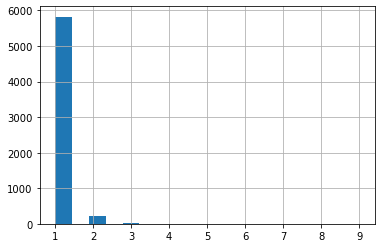

In [9]:
counts = train_images["StudyInstanceUID"].value_counts()
display(dict(enumerate(np.bincount(counts))))
ax = counts.hist(bins=2*max(counts))

See sanity chek that sumof labels is equls to nb samples and show case/label distibution

Missed: 0
6054 == 6054


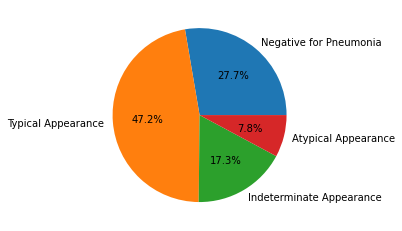

In [10]:
train_study_ids = set(train_study["id_"])
miss = [id_ for id_ in train_images["StudyInstanceUID"] if id_ not in train_study_ids]
print(f"Missed: {len(miss)}")
print(f"{len(train_study)} == {train_study[list(LABELS)].sum().sum()}")

ax = train_study[list(LABELS)].sum().plot.pie(ylabel="", autopct="%.1f%%")

### Fuse the two tables

lets trasfer the labels to the images

In [11]:
train_images = pd.merge(train_images, train_study, how="left", left_on="StudyInstanceUID", right_on="id_")
display(train_images.head())

,boxes,label,StudyInstanceUID,name,#boxes,path,label_,label__,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id_,class
0,"[{'x': 720.65215, 'y': 636.51048, 'width': 332...",opacity 1 720.65215 636.51048 1052.84563 1284....,00086460a852,65761e66de9f,2,train/00086460a852/9e8302230c91/65761e66de9f.dcm,"[opacity, opacity]",{opacity},0,1,0,0,00086460a852,1
1,None,none 1 0 0 1 1,000c9c05fd14,51759b5579bc,0,train/000c9c05fd14/e555410bd2cd/51759b5579bc.dcm,[none],{none},0,0,0,1,000c9c05fd14,3
2,None,none 1 0 0 1 1,00292f8c37bd,f6293b1c49e2,0,train/00292f8c37bd/73120b4a13cb/f6293b1c49e2.dcm,[none],{none},1,0,0,0,00292f8c37bd,0
3,None,none 1 0 0 1 1,005057b3f880,3019399c31f4,0,train/005057b3f880/e34afce999c5/3019399c31f4.dcm,[none],{none},1,0,0,0,005057b3f880,0
4,"[{'x': 812.54698, 'y': 1376.41291, 'width': 62...",opacity 1 812.54698 1376.41291 1435.14793 1806...,0051d9b12e72,bb4b1da810f3,2,train/0051d9b12e72/152f6ec68d86/bb4b1da810f3.dcm,"[opacity, opacity]",{opacity},0,0,0,1,0051d9b12e72,3


### Prune duplicate

comming from the discussion that cases without annottaion and there are multiple images per study, the ones without boxes are invalide

In [12]:
train_images_clean = []
for uid, dfg in train_images.groupby("StudyInstanceUID"):
    if len(dfg) > 1:
        dfg.sort_values("#boxes", inplace=True, ascending=False)
    train_images_clean.append(dict(dfg.iloc[0]))

print(f"{len(train_images)} >> {len(train_images_clean)}")
train_images = pd.DataFrame(train_images_clean)

6334 >> 6054


Show proportion of classes hen no booundinx boxes are not provided

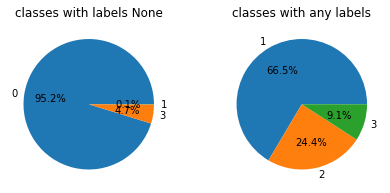

In [13]:
fig, axarr = plt.subplots(ncols=2, figsize=(7, 3))

train_images_none = train_images[train_images["label"].str.startswith("none")]
axarr[0].set_title("classes with labels None")
ax = train_images_none["class"].value_counts().plot.pie(ax=axarr[0], ylabel="", autopct="%.1f%%")

train_images_other = train_images[~ train_images["label"].str.startswith("none")]
axarr[1].set_title("classes with any labels")
ax = train_images_other["class"].value_counts().plot.pie(ax=axarr[1], ylabel="", autopct="%.1f%%")

### Show sample image

dict_keys(['_parent_encoding', '_dict', 'is_decompressed', 'read_little_endian', 'read_implicit_vr', 'read_encoding', 'is_little_endian', 'is_implicit_VR', 'parent', '_private_blocks', '_pixel_array', '_pixel_id', 'preamble', 'file_meta', 'fileobj_type', 'timestamp', 'filename'])
Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.59189821846420219299438915042640676800
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 65761e66de9f
(0008, 0020) Study Date                        

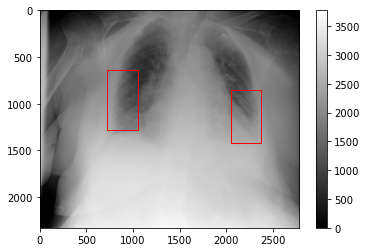

In [14]:
import pydicom
from pydicom.pixel_data_handlers import apply_voi_lut

idx_ = 0
dicom_path = os.path.join(BASE_PATH, train_images["path"][idx_])
dicom = pydicom.dcmread(dicom_path)
print(vars(dicom).keys())
print(dicom)
img = apply_voi_lut(dicom.pixel_array, dicom)


import matplotlib.pyplot as plt
from matplotlib import patches

fig, ax = plt.subplots()
ax_im = ax.imshow(img, cmap="gray")
for bbox in train_images["boxes"][idx_]:
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox['x'], bbox['y']), bbox['width'], bbox['height'], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

_= plt.colorbar(ax_im)

### Samples per class

show a few sample images per class

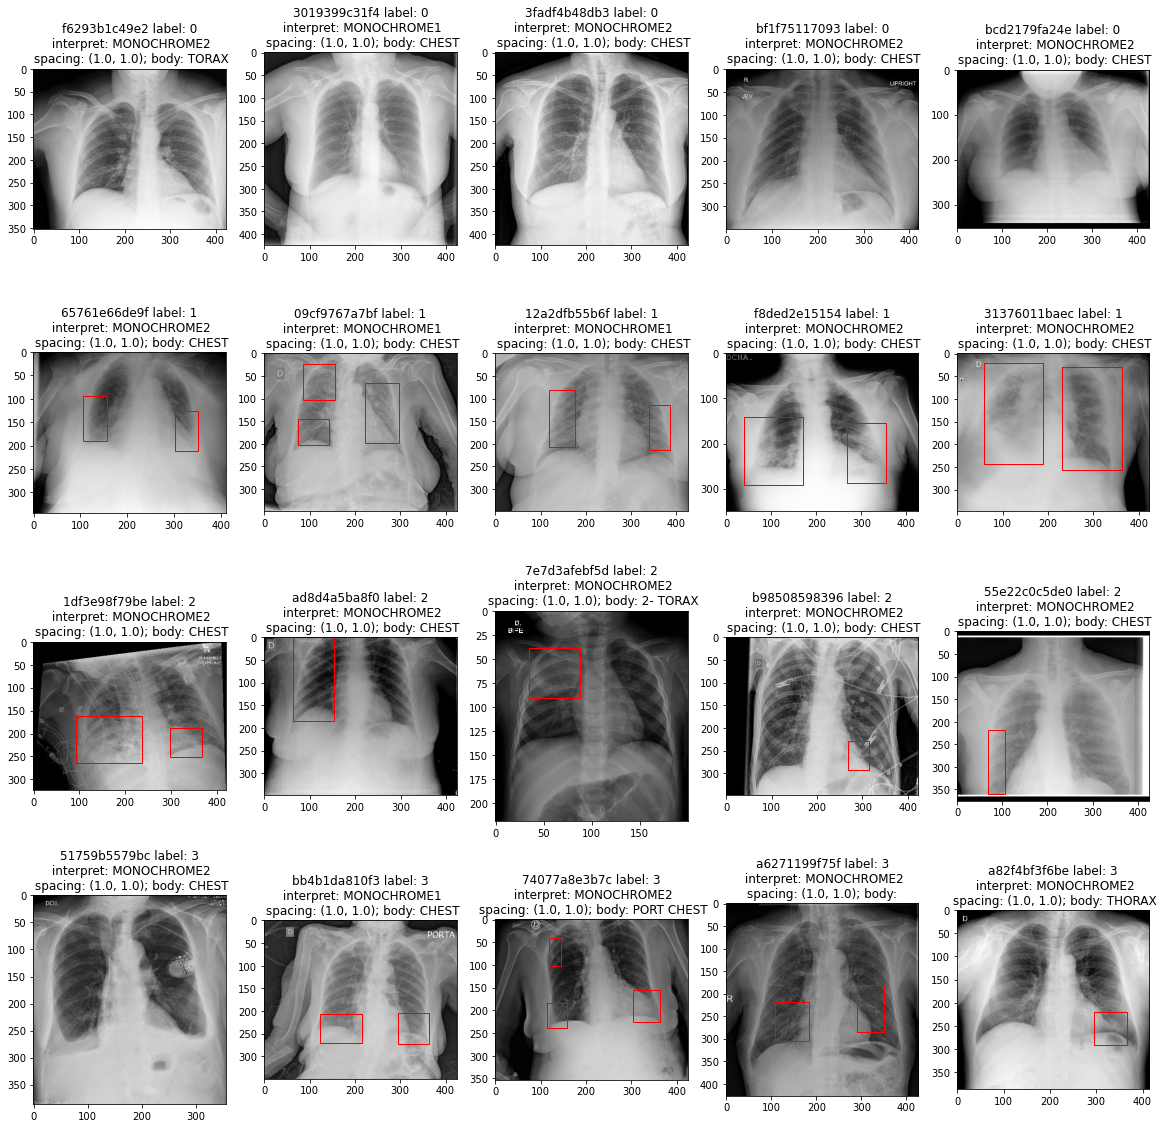

In [15]:
from kaggle_covid.utils import load_image

NB_SAMPLES = 5
NB_CLASSES = max(train_images["class"]) + 1
rect_property = dict(linewidth=1, edgecolor='r', facecolor='none')

fig, axarr = plt.subplots(nrows=NB_CLASSES, ncols=NB_SAMPLES, figsize=(NB_SAMPLES * 4, NB_CLASSES * 5))
for cls, df in train_images.groupby("class"):
    for i, (_, row) in enumerate(df[:NB_SAMPLES].iterrows()):
        img, meta = load_image(os.path.join(BASE_PATH, row["path"]), dict(row), spacing=1.)
        axarr[cls, i].set_title(f"{row['name']} label: {cls}\n interpret: {meta['interpret']}\n spacing: {meta['spacing']}; body: {meta['body']}")
        if img is None:
            continue
        _ = axarr[cls, i].imshow(img.astype(float) / img.max(), cmap="gray")
        if not meta["boxes"]:
            continue
        for bbox in meta["boxes"]:
            rect = patches.Rectangle((bbox['x'], bbox['y']), bbox['width'], bbox['height'], **rect_property)
            axarr[cls, i].add_patch(rect)

### Number of detections per case

Histgram of number of detections in subject depending on type

,0,2,3,1,4,8,5
Negative for Pneumonia,1676.0,NaN,NaN,NaN,NaN,NaN,NaN
Typical Appearance,1.0,2653.0,152.0,27.0,21.0,1.0,NaN
Indeterminate Appearance,NaN,345.0,17.0,685.0,1.0,NaN,1.0
Atypical Appearance,83.0,115.0,14.0,261.0,1.0,NaN,NaN


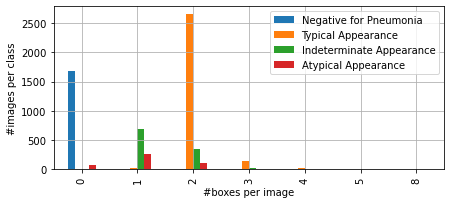

In [16]:
counts, cases = [], []
for cls, df in train_images.groupby("class"):
    counts.append(dict(df["#boxes"].value_counts()))
    cases.append(LABELS[cls])

df = pd.DataFrame(counts, index=cases)
display(df)
ax = df[sorted(df.columns)].T.plot.bar(grid=True, xlabel="#boxes per image", ylabel="#images per class", figsize=(7, 3))

In [17]:
# import tqdm

# train_images['BodyPart'] = [pydicom.dcmread(os.path.join(BASE_PATH, p)).BodyPartExamined for p in tqdm.tqdm(train_images['path'])]

# counts, cases = [], []
# for cls, df in train_images.groupby("class"):
#     counts.append(dict(df["BodyPart"].value_counts()))
#     cases.append(LABELS[cls])

# ax = pd.DataFrame(counts, index=cases).T.plot.bar(grid=True, xlabel="BodyPart", ylabel="#images", figsize=(8, 3))

## Convert to COCO

The *.txt file specifications are:

- One row per object - class x_center y_center width height
- Box coordinates must be in normalized xywh format (from 0 - 1)
- Class numbers are zero-indexed

<img src="https://user-images.githubusercontent.com/26833433/91506361-c7965000-e886-11ea-8291-c72b98c25eec.jpg" width="480">

In [18]:
SPACING = 0.25
PATH_OUT = f"/home/jovyan/work/coco-dataset_spacing-{SPACING}"
PATH_OUT_IMAGE = os.path.join(PATH_OUT, "images")
PATH_OUT_LABEL = os.path.join(PATH_OUT, "labels")

for d in (PATH_OUT_IMAGE, PATH_OUT_LABEL):
    os.makedirs(d, exist_ok=True)
    for dd in ("train", "test"):
        os.makedirs(os.path.join(d, dd), exist_ok=True)

In [21]:
from tqdm.autonotebook import tqdm
from multiprocessing import Pool
from functools import partial
from kaggle_covid.utils import convert_image_dicom_to_coco

convert_train_image = partial(
    convert_image_dicom_to_coco,
    spacing=SPACING,
    dataset_path=BASE_PATH,
    path_images=os.path.join(PATH_OUT_IMAGE, "train"),
    path_labels=os.path.join(PATH_OUT_LABEL, "train"),
)

metas = []
pool = Pool(os.cpu_count())
pbar = tqdm(total=len(train_images))
for meta in pool.imap_unordered(convert_train_image, train_images.iterrows()):
    metas.append(meta)
    pbar.update()
pool.close()
pool.join()

  0%|          | 0/6054 [00:00<?, ?it/s]

/home/jovyan/conda/lib/python3.8/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:345: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


4


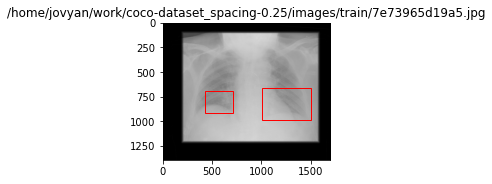

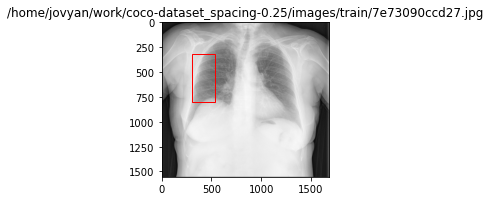

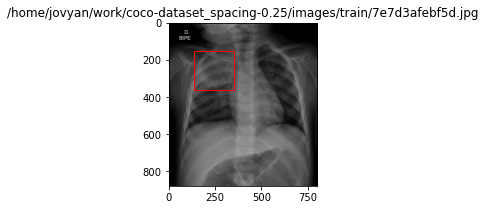

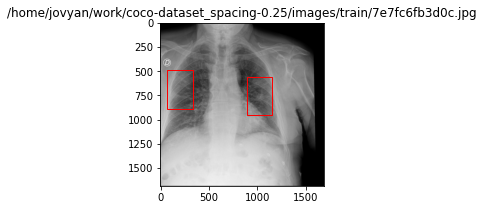

In [ ]:
import glob
import os
import matplotlib.pylab as plt
import pandas as pd
from matplotlib import patches

TEMP_IMAGES = glob.glob(os.path.join(PATH_OUT_IMAGE, 'train', '7e7*jpg'))
print(len(TEMP_IMAGES))
rect_property = dict(linewidth=1, edgecolor='r', facecolor='none')

for p_img in TEMP_IMAGES[:9]:
    p_lbs = p_img.replace(PATH_OUT_IMAGE, PATH_OUT_LABEL).replace('.jpg', '.txt')
    img = plt.imread(p_img)
    try:
        lbs = pd.read_csv(p_lbs, index_col=None, header=None, sep=" ")
    except:
        print(p_lbs)
        continue
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)
    ih, iw = img.shape[:2]
    for bbox in lbs.values:
        cls, x_center, y_center, width, height = bbox
        x = (x_center - width / 2.) * iw
        y = (y_center - height / 2.) * ih
        rect = patches.Rectangle((x, y), int(width * iw), int(height * ih), **rect_property)
        ax.add_patch(rect)
    ax.set_title(p_img)
    # fig.show()

In [ ]:
from kaggle_covid.utils import generate_coco_annotations

generate_coco_annotations(metas, labels=LABELS, path_json=os.path.join(PATH_OUT, "covid_train.json"))

In [ ]:
found_images = glob.glob(os.path.join(BASE_PATH, 'test', '*', '*', '*.dcm'))

test_images = pd.DataFrame([{
    "name": os.path.splitext(os.path.basename(p))[0],
    "path": os.path.sep.join(p.split(os.path.sep)[-4:]),
    "study": p.split(os.path.sep)[-3],
} for p in found_images])
display(test_images.head())

convert_test_image = partial(
    convert_image_dicom_to_coco,
    spacing=SPACING,
    dataset_path=BASE_PATH,
    path_images=os.path.join(PATH_OUT_IMAGE, "test"),
    path_labels=os.path.join(PATH_OUT_LABEL, "test"),
)

pool = Pool(os.cpu_count())
test_images = list(pool.imap_unordered(convert_test_image, tqdm(test_images.iterrows(), total=len(test_images))))
pool.close()
pool.join()

test_images = pd.DataFrame(test_images)
display(test_images.head())

,name,path,study
0,4f7f40e478b1,test/9260839a059d/5e71d813bb94/4f7f40e478b1.dcm,9260839a059d
1,6ce67071aa0e,test/c6ce9fc03d44/3af8b9fec0cc/6ce67071aa0e.dcm,c6ce9fc03d44
2,ab276c041ef9,test/0f78e4f5c662/67c3cae425a6/ab276c041ef9.dcm,0f78e4f5c662
3,44b12000b7bf,test/4019c1fe14bf/9d46a07eaf37/44b12000b7bf.dcm,4019c1fe14bf
4,130aa9d3716d,test/102b201f8074/e3a90b26663b/130aa9d3716d.dcm,102b201f8074


  0%|          | 0/1263 [00:00<?, ?it/s]

,name,path,study,boxes,body,interpret,original_spacing,original_image_shape,spacing,image_shape,bboxes
0,9bce1b51617d,test/8f15be256d40/66c6415bbe6e/9bce1b51617d.dcm,8f15be256d40,[],CHEST,MONOCHROME1,"[0.15, 0.15]","(2336, 2700)","(0.25, 0.25)","(1401, 1620)",[]
1,130aa9d3716d,test/102b201f8074/e3a90b26663b/130aa9d3716d.dcm,102b201f8074,[],CHEST,MONOCHROME2,"[0.125, 0.125]","(2580, 3050)","(0.25, 0.25)","(1290, 1525)",[]
2,4f7f40e478b1,test/9260839a059d/5e71d813bb94/4f7f40e478b1.dcm,9260839a059d,[],CHEST,MONOCHROME1,"[0.148, 0.148]","(2874, 2808)","(0.25, 0.25)","(1701, 1662)",[]
3,6ce67071aa0e,test/c6ce9fc03d44/3af8b9fec0cc/6ce67071aa0e.dcm,c6ce9fc03d44,[],CHEST,MONOCHROME1,"[0.15, 0.15]","(2336, 2797)","(0.25, 0.25)","(1401, 1678)",[]
4,44b12000b7bf,test/4019c1fe14bf/9d46a07eaf37/44b12000b7bf.dcm,4019c1fe14bf,[],CHEST,MONOCHROME2,"[0.1, 0.1]","(3480, 4248)","(0.25, 0.25)","(1392, 1699)",[]


In [ ]:
! cd /home/jovyan/work/
! zip coco-dataset_spacing-0.5.zip -q -r coco-dataset_spacing-0.5/
! ls -l

total 89392052
drwxrwsr-x  4 jovyan users        4096 Aug  9 08:12 coco-dataset_spacing-0.25
-rw-rw-r--  1 jovyan users  1236456572 Aug 11 17:02 coco-dataset_spacing-0.25.zip
drwxrwsr-x  4 jovyan users        4096 Aug  9 14:49 coco-dataset_spacing-0.5
-rw-rw-r--  1 jovyan users   372498438 Aug 11 23:12 coco-dataset_spacing-0.5.zip
drwxrwsr-x  4 jovyan users        4096 Aug  5 23:57 coco-dataset_spacing-0.75
-rw-rw-r--  1 jovyan users   190963332 Aug 11 16:52 coco-dataset_spacing-0.75.zip
-rw-rw-r--  1 jovyan users     1083264 Aug 11 23:06 COVID-detection-with-Lightning-Flash.ipynb
-rw-r--r--  1 jovyan users        5050 Aug 11 22:35 kaggle_COVID_detection-0.1.0-py3-none-any.whl
drwxr-sr-x 13 jovyan users        4096 Aug 11 17:08 lightning-flash
drwxrwsr-x 24 jovyan users        4096 Aug  7 08:07 lightning_logs
drwxrwsr-x  3 jovyan users        4096 Aug  7 12:53 logs
-rw-rw-r--  1 jovyan users   404636165 Aug 11 23:01 object_detection_model.pt
drwxrwsr-x  5 jovyan users        4096 Aug  

## Training with Flash

In [ ]:
! rm -rf lightning-flash
! pip uninstall -y lightning-flash
! git clone https://github.com/PyTorchLightning/lightning-flash.git
! cd lightning-flash && git checkout feature/icevision && pip install -q .[image]
# ! pip install -q https://github.com/PyTorchLightning/lightning-flash/archive/refs/heads/feature/icevision.zip#egg=lightning-flash[image]
! pip uninstall -y fiftyone wandb
# ! pip install -q effdet

In [27]:
import flash
import flash.core.integrations.icevision
print(flash.__version__)

0.5.0dev


In [28]:
from flash.image import ObjectDetectionData, ObjectDetector

IMAGE_SIZE = 512

# 1. Create the DataModule
dm = ObjectDetectionData.from_coco(
    train_folder=os.path.join(PATH_OUT_IMAGE, 'train'),
    train_ann_file=os.path.join(PATH_OUT, "covid_train.json"),
    val_split=0.1,
    batch_size=8,
    image_size=IMAGE_SIZE,
)

  0%|          | 0/7853 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/4294 [00:00<?, ?it/s]

In [29]:
print(ObjectDetector.available_backbones())
# print(ObjectDetector.available_heads())

{'efficientdet': ['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd7x', 'tf_d0', 'tf_d0_ap', 'tf_d1', 'tf_d1_ap', 'tf_d2', 'tf_d2_ap', 'tf_d3', 'tf_d3_ap', 'tf_d4', 'tf_d4_ap', 'tf_d5', 'tf_d5_ap', 'tf_d6', 'tf_d7', 'tf_d7x', 'tf_lite0', 'tf_lite1', 'tf_lite2', 'tf_lite3'], 'faster_rcnn': ['mobilenet', 'resnet101', 'resnet101_fpn', 'resnet152', 'resnet152_fpn', 'resnet18', 'resnet18_fpn', 'resnet34', 'resnet34_fpn', 'resnet50', 'resnet50_fpn', 'resnext101_32x8d', 'resnext101_32x8d_fpn', 'resnext50_32x4d_fpn', 'wide_resnet101_2_fpn', 'wide_resnet50_2_fpn'], 'retinanet': ['resnet101_fpn', 'resnet152_fpn', 'resnet18_fpn', 'resnet34_fpn', 'resnet50_fpn', 'resnext101_32x8d_fpn', 'resnext50_32x4d_fpn', 'wide_resnet101_2_fpn', 'wide_resnet50_2_fpn']}


In [30]:
# 2. Build the task
model = ObjectDetector(
    head="efficientdet",
    backbone="tf_d5_ap",
    optimizer=torch.optim.AdamW,
    learning_rate=1e-5,
    num_classes=dm.num_classes,
    image_size=IMAGE_SIZE,
)

Using 'efficientdet' provided by airctic/IceVision (https://github.com/airctic/icevision) and rwightman/efficientdet-pytorch (https://github.com/rwightman/efficientdet-pytorch).


In [ ]:
import pytorch_lightning as pl
print(pl.__version__)
logger = pl.loggers.CSVLogger(save_dir='logs/')
                              
# 3. Create the trainer and finetune the model
trainer = flash.Trainer(
    max_epochs=50,
    gpus=1,
    precision=16,
    accumulate_grad_batches=24,
    logger=logger,
    val_check_interval=0.5,
)
trainer.finetune(model, datamodule=dm, strategy="freeze_unfreeze")

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.4.1



  | Name          | Type                            | Params
------------------------------------------------------------------
0 | train_metrics | ModuleDict                      | 0     
1 | val_metrics   | ModuleDict                      | 0     
2 | adapter       | IceVisionObjectDetectionAdapter | 33.4 M
------------------------------------------------------------------
6.1 M     Trainable params
27.3 M    Non-trainable params
33.4 M    Total params
133.708   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/jovyan/conda/lib/python3.8/site-packages/flash/core/model.py:536: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  if self.datamodule is not None and getattr(self.datamodule, "data_pipeline", None) is not None:
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/properties.py:301: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_progress_bar_dict()` in `LightingModule`.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/jovyan/conda/lib/python3.8/site-packages/flash/core/model.py:685: UserWarning: DataPipeline couldn't be added to the checkpoint.
  rank_zero_warn("DataPipeline couldn't be added to the checkpoint.")


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [40]:
# 3. Save the model!
trainer.save_checkpoint("object_detection_model.pt")

/home/jovyan/conda/lib/python3.8/site-packages/flash/core/model.py:685: UserWarning: DataPipeline couldn't be added to the checkpoint.
  rank_zero_warn("DataPipeline couldn't be added to the checkpoint.")


,loss,class_loss,box_loss,"Precision (IoU=0.50:0.95,area=all)","Recall (IoU=0.50:0.95,area=all,maxDets=100)",epoch,step
0,1.698580,1.134949,0.011273,0.000287,0.006233,0,10
1,1.677176,1.155806,0.010427,0.001384,0.017372,0,20
2,1.609115,1.121717,0.009748,0.000791,0.010928,1,31
3,1.551566,1.082433,0.009383,0.000942,0.011990,1,41
4,1.479926,1.047935,0.008640,NaN,NaN,2,49


<AxesSubplot:xlabel='epoch'>

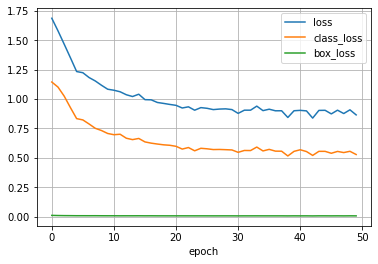

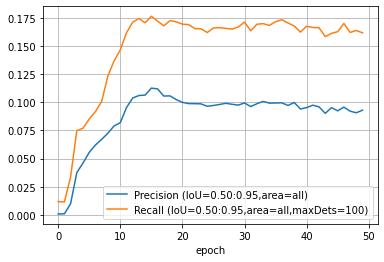

In [41]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
display(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['loss', 'class_loss', 'box_loss']].plot(grid=True, legend=True, xlabel=agg_col)
df_metrics[['Precision (IoU=0.50:0.95,area=all)', 'Recall (IoU=0.50:0.95,area=all,maxDets=100)']].plot(grid=True, legend=True, xlabel=agg_col)

### Predictions from saved model

In [ ]:
from tqdm import tqdm
from flash.image.detection.data import ObjectDetectionPreprocess

model2 = ObjectDetector.load_from_checkpoint("object_detection_model.pt", pretrained=False)
model2._preprocess = ObjectDetectionPreprocess(image_size=IMAGE_SIZE)
display(test_images.head())

# 4. Detect objects in a few images!
predictions = []
model2.to("cuda")
for _, row in tqdm(test_images.iterrows(), total=len(test_images)):
    p_img = os.path.join(PATH_OUT_IMAGE, "test", f"{row['name']}.jpg")
    preds = model2.predict([p_img])
    rec = {**dict(row), "predictions": preds[0]}
    predictions.append(rec)

Images in the test set may contain more than one object.
For each object in a given test image, you must predict a class ID of "opacity", a confidence score, and bounding box in format xmin ymin xmax ymax.

If you predict that there are NO objects in a given image, you should predict none 1.0 0 0 1 1, where none is the class ID for "No finding", 1.0 is the confidence, and 0 0 1 1 is a one-pixel bounding box.

In [43]:
print(predictions[0])
display(predictions[0]['predictions'].as_dict)

{'name': '9bce1b51617d', 'path': 'test/8f15be256d40/66c6415bbe6e/9bce1b51617d.dcm', 'study': '8f15be256d40', 'boxes': [], 'body': 'CHEST', 'interpret': 'MONOCHROME1', 'original_spacing': [0.15, 0.15], 'original_image_shape': (2336, 2700), 'spacing': (0.25, 0.25), 'image_shape': (1401, 1620), 'bboxes': [], 'predictions': <icevision.data.prediction.Prediction object at 0x7f89fbecaa00>}


<bound method BaseRecord.as_dict of BaseRecord

common: 
	- Image size ImgSize(width=512, height=512)
	- Img: None
	- Record ID: None
detection: 
	- BBoxes: []
	- Class Map: None
	- Labels: []
	- Scores: []>

In [44]:
pred_boxes = [len(p['predictions'].as_dict()['detection']['bboxes']) for p in predictions]
print(dict(enumerate(np.bincount(pred_boxes))))
print(pred_boxes)

{0: 977, 1: 134, 2: 152}
[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0,

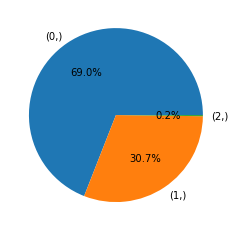

In [45]:
det_classes = []
for rec in predictions:
    lbs = rec['predictions'].as_dict()['detection']['label_ids']
    det_classes += lbs or [0]

ax = pd.DataFrame(det_classes).value_counts().plot.pie(ylabel="", autopct="%.1f%%")

In [46]:
import gc, torch

# del model, trainer
torch.cuda.empty_cache()
gc.collect()

87425

In [47]:
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/